#### Load

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
train=pd.read_csv('train.csv',index_col=0)
test=pd.read_csv('test_x.csv',index_col=0)
submission=pd.read_csv('sample_submission.csv')

In [101]:
train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

#### 특징

1. 동의하지않음 비율 ( age_group, education, engnat) 
2. Question Time 적게는 1분에서 많게는 30분인 질문들 즉, 시간이 너무 많이 쓴 데이터 제거. (사람 평균 200 밀리초) [link](https://news.joins.com/article/2869262) 출처 : [link](https://openpsychometrics.org/)
3. 종교 (0,1,11),(2,7,9,10),(3,4,5,6,8)
4. tp - 0~7 수준 나누기 0 12 345 67
5. 교육수준 0,2 묶기 1 3,4 묶기
6. 인종 아랍,아시아 묶기 블랙 호주 아메리칸 아더 묶기 와이트
7. 결혼 했냐 안했냐로 0,1 2,3 묶기 
8. 나이 10대 20,30 대 40,50 대 60,70대 
9. drop ( engnat familysize gender hand urban )

#### 모델 후
1. race, 질문이 중요

#### time

In [102]:
cols=[col for col in train.columns if 'E' in col]

In [103]:
def removeOutlier(df):
    for col in cols:
        sub=df[col]
        lower=sub.quantile(0.001)
        upper=sub.quantile(0.999)
        sub=sub[(sub>=lower)&(sub<=upper)]
        df[col]=sub
    return df

train=removeOutlier(train)
train=train.dropna()

#### religion

In [104]:
religionMap={
    'Agnostic':0,
    'Atheist':0,
    'Buddhist':1,
    'Hindu':1,
    'Muslim':1,
    'Sikh':1,
    'Christian_Catholic':2,
    'Christian_Mormon':2,
    'Christian_Protestant':2,
    'Christian_Other':2,
    'Jewish':2,
    'Other':3
}

train['religion']=train['religion'].map(religionMap)
test['religion']=test['religion'].map(religionMap)

#### education

In [105]:
educationMap={
    0:0,
    1:0,
    2:0,
    3:1,
    4:1
}

train['education']=train['education'].map(educationMap)
test['education']=test['education'].map(educationMap)

#### race

In [106]:
raceMap={
    'Asian':2,
    'Arab':2,
    'Black':1,
    'Indigenous Australian':1,
    'Native American':1,
    'Other':1,
    'White':0
}

train['race']=train['race'].map(raceMap)
test['race']=test['race'].map(raceMap)

#### married

In [107]:
marriedMap={
    0:0,
    1:0,
    2:1,
    3:1
}

train['married']=train['married'].map(marriedMap)
test['married']=test['married'].map(marriedMap)

#### age

In [108]:
def ageBand(x):
    if x=='10s':
        return 0
    elif (x=='20s')or(x=='30s'):
        return 1
    elif (x=='40s')or(x=='50s'):
        return 2
    elif (x=='60s')or(x=='+70s'):
        return 3
    
train['age_group']=train['age_group'].apply(ageBand)
test['age_group']=test['age_group'].apply(ageBand)

#### tp

In [11]:
def Filter(x):
    if x<1:
        return 0
    if x<3:
        return 0
    elif x<6:
        return 1
    else:
        return 2
    
cols=[col for col in train.columns if 'tp' in col]

def get_tp(df):
    for col in cols:
        df[col]=df[col].apply(Filter)
    return df

train=get_tp(train)
test=get_tp(test)

#### question

In [109]:
group45=['QaA','QqA']
group1=['QbA','QcA','QoA','QpA','QsA','QtA']
group12=['QjA','QmA']

cols=[col for col in train.columns if 'A' in col]
dropCol=[]
def question(df):
    for col in cols:
        if col in group1:
            df[col]=df[col].map({1:1,2:0,3:0,4:0,5:0})
        elif col in group12:
            df[col]=df[col].map({1:1,2:1,3:0,4:0,5:0})
        elif col in group45:
            df[col]=df[col].map({1:0,2:0,3:0,4:1,5:1})
        else:
            dropCol.append(col)
    return df

train=question(train)
test=question(test)

In [110]:
train=train.drop(dropCol,axis=1)
test=test.drop(dropCol,axis=1)

#### familysize

In [111]:
def removeOutlier(df,col):
    sub=df[col]
    lower=sub.quantile(0.001)
    upper=sub.quantile(0.999)
    sub=sub[(sub>=lower)&(sub<=upper)]
    df[col]=sub
    return df

train=removeOutlier(train,'familysize')
train=train[~train['familysize'].isna()]

#### gender

In [112]:
train['gender']=train['gender'].map({'Female':0,'Male':1})
test['gender']=test['gender'].map({'Female':0,'Male':1})

#### not used cols

In [113]:
not_usecols=['engnat','hand','urban','wf_01','wf_02','wf_03',
             'wr_01','wr_02','wr_03','wr_04','wr_05','wr_06',
             'wr_07','wr_08','wr_09','wr_10','wr_11','wr_12','wr_13']

def change(df):
    for col in not_usecols:
        df=df.drop(col,axis=1)
    return df

train=change(train)
test=change(test)

#### mean encoding

In [114]:
from sklearn.model_selection import StratifiedKFold

kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)
cols=['age_group', 'education', 'married', 'race', 'religion']
globalMean=train['voted'].mean()
alpha=5
encode_=pd.DataFrame()

for col in cols:
    parts=[]
    for train_idx,valid_idx in kfold.split(train.drop('voted',axis=1),train['voted']):
        X_tr,X_val=train.iloc[train_idx],train.iloc[valid_idx]
        nrows=X_tr.groupby(col)['voted'].count()
        mean=X_tr.groupby(col)['voted'].mean()
        smooth=(mean*nrows+globalMean*alpha)/(alpha+nrows)
        test[f'mean_{col}']=test[col].map(smooth)
        encoded=X_val[col].map(smooth)
        parts.append(encoded)
    encode=pd.concat(parts,axis=0)
    encode_=pd.concat([encode_,encode],axis=1)
encode_=encode_.sort_index()
encode_.columns=[f"mean_{col}" for col in encode_.columns]
train=pd.concat([train,encode_],axis=1)

#### frequent encoding

In [15]:
cols=['age_group','education','married','race','religion']

for col in cols:
    freqMap=train.groupby(col)['voted'].count()/train.shape[0]
    
    train[f'freq_{col}']=train[col].map(freqMap)
    test[f'freq_{col}']=test[col].map(freqMap)

#### split X,y

In [115]:
train['voted']=train['voted'].map({2:1,1:0})

In [116]:
X=train.drop('voted',axis=1)
y=train['voted']

In [117]:
import lightgbm
from sklearn.model_selection import StratifiedKFold

cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=2020)

preds=[]
models=[]
params={
    'objective':'binary',
    'metric':'binary_logloss',
    'unbalance':True,
    'learning_rate':0.04,
    'verbosity':-1
}

for train_idx,valid_idx in cv.split(X,y):
    X_tr,X_val=X.iloc[train_idx],X.iloc[valid_idx]
    y_tr,y_val=y.iloc[train_idx],y.iloc[valid_idx]
    
    lgb_train=lightgbm.Dataset(X_tr,y_tr)
    lgb_valid=lightgbm.Dataset(X_val,y_val,reference=lgb_train)
    
    model=lightgbm.train(params,lgb_train,num_boost_round=2000,valid_sets=[lgb_valid],
                        early_stopping_rounds=70,verbose_eval=0)
    models.append(model)
    pred=model.predict(test,num_iteration=model.best_iteration)
    preds.append(pred)
print("done")

Training until validation scores don't improve for 70 rounds
[50]	valid_0's binary_logloss: 0.579294
[100]	valid_0's binary_logloss: 0.576479
[150]	valid_0's binary_logloss: 0.576682
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.57644
Training until validation scores don't improve for 70 rounds
[50]	valid_0's binary_logloss: 0.578728
[100]	valid_0's binary_logloss: 0.575225
[150]	valid_0's binary_logloss: 0.574792
[200]	valid_0's binary_logloss: 0.574713
[250]	valid_0's binary_logloss: 0.574858
[300]	valid_0's binary_logloss: 0.575566
Early stopping, best iteration is:
[230]	valid_0's binary_logloss: 0.574527
Training until validation scores don't improve for 70 rounds
[50]	valid_0's binary_logloss: 0.583255
[100]	valid_0's binary_logloss: 0.580538
[150]	valid_0's binary_logloss: 0.58117
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.580338
Training until validation scores don't improve for 70 rounds
[50]	valid_0's binary_logloss: 0.583656
[

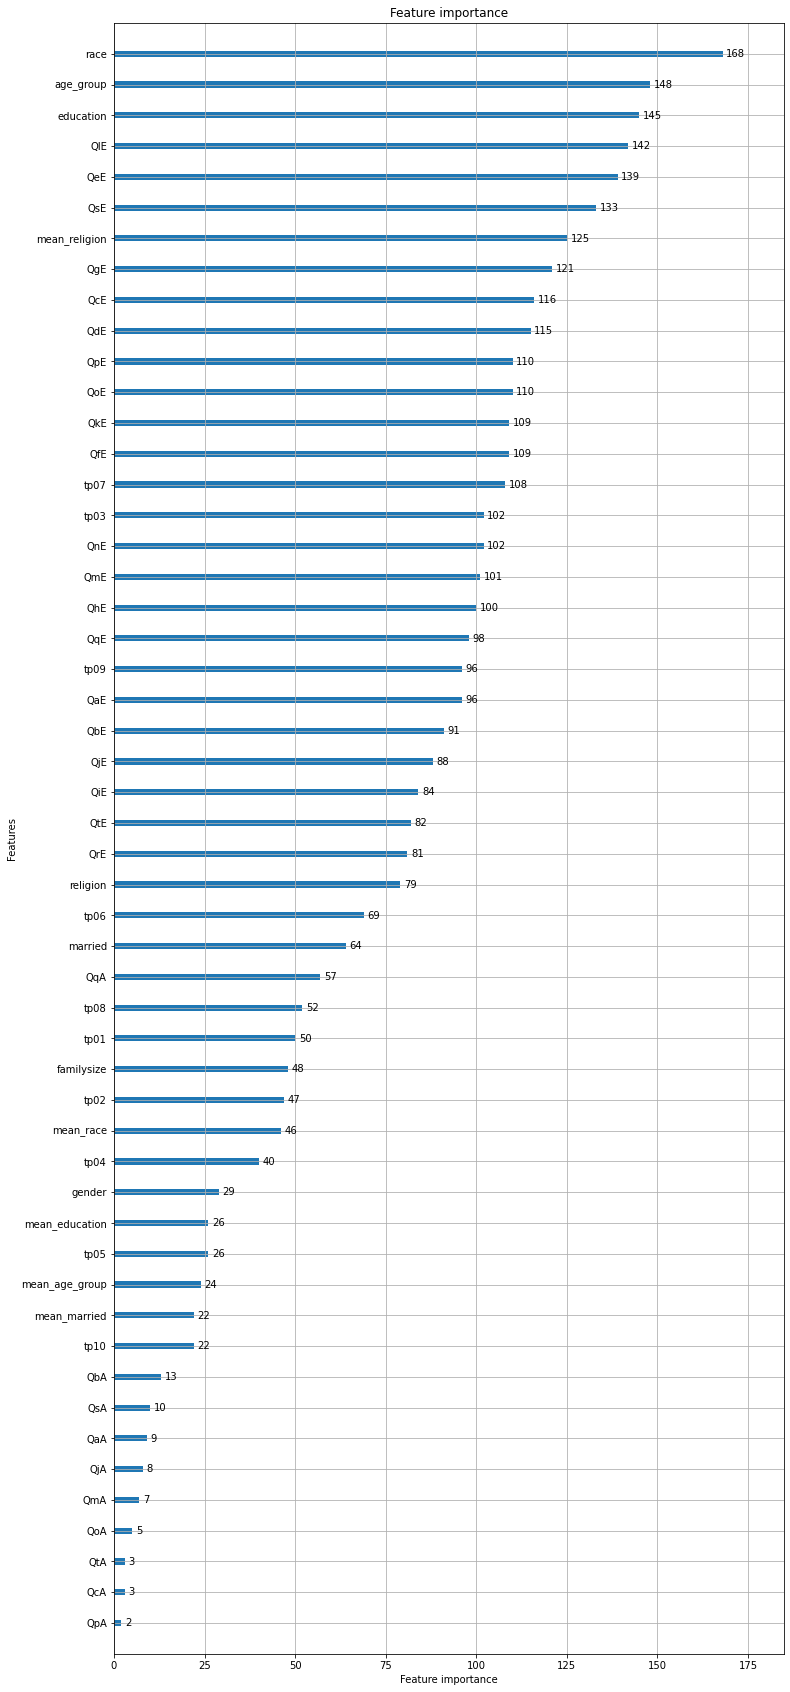

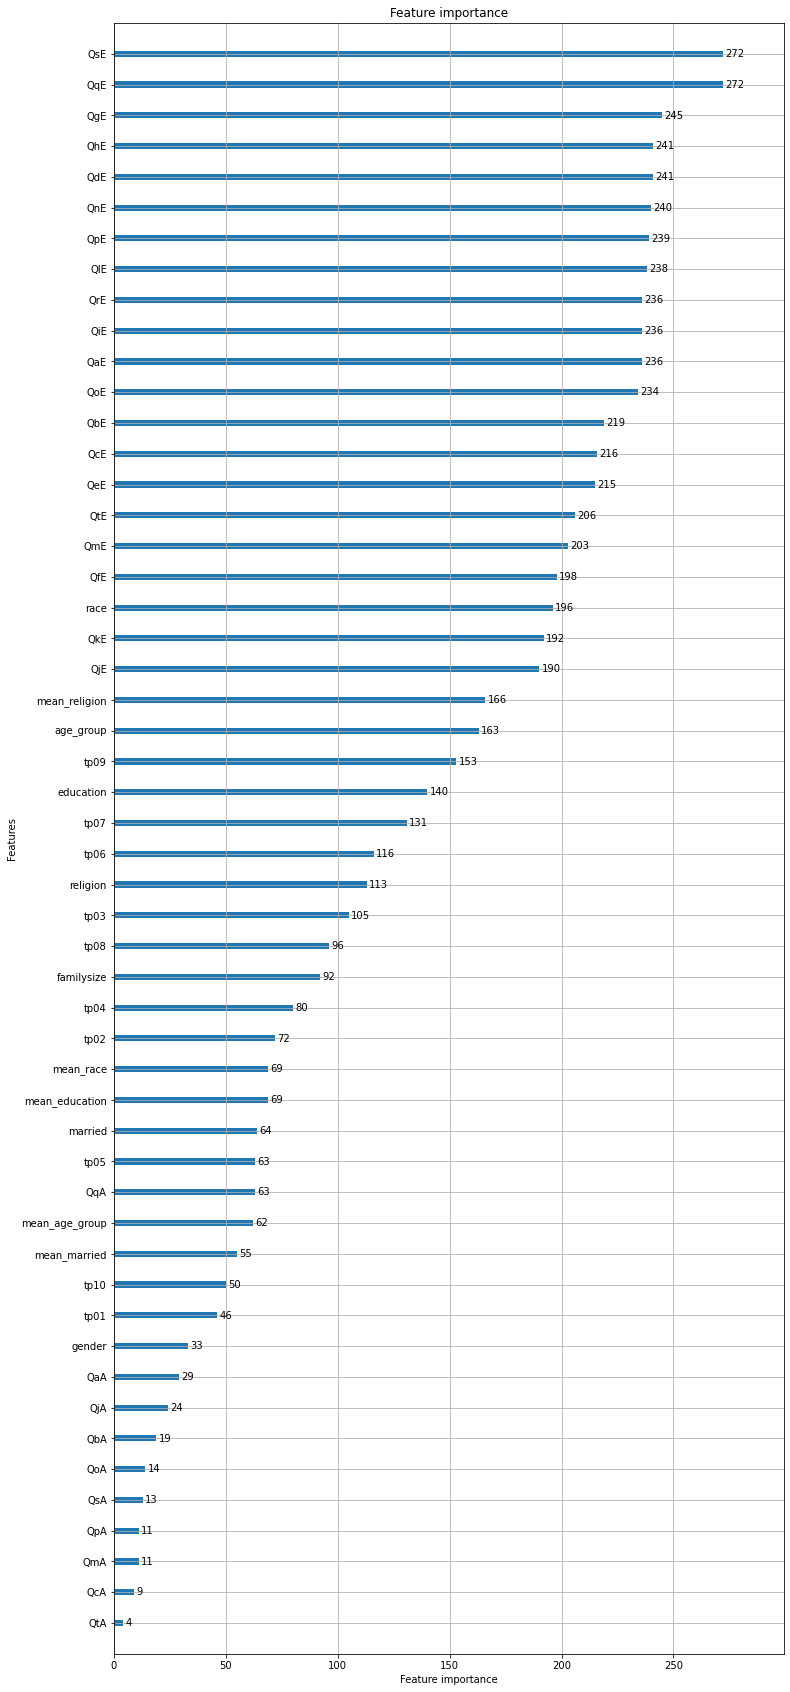

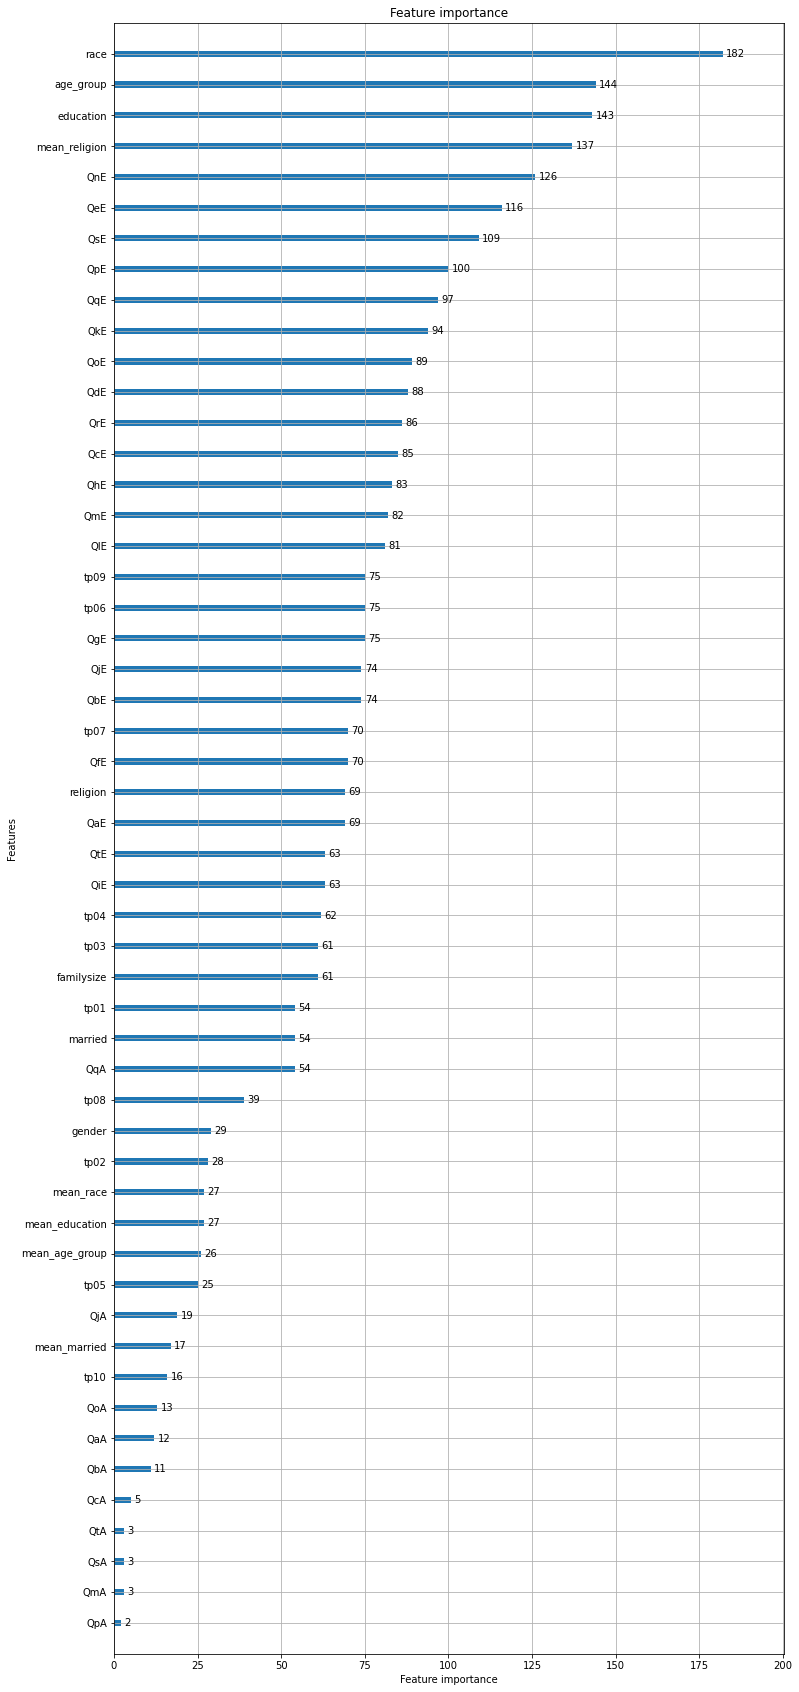

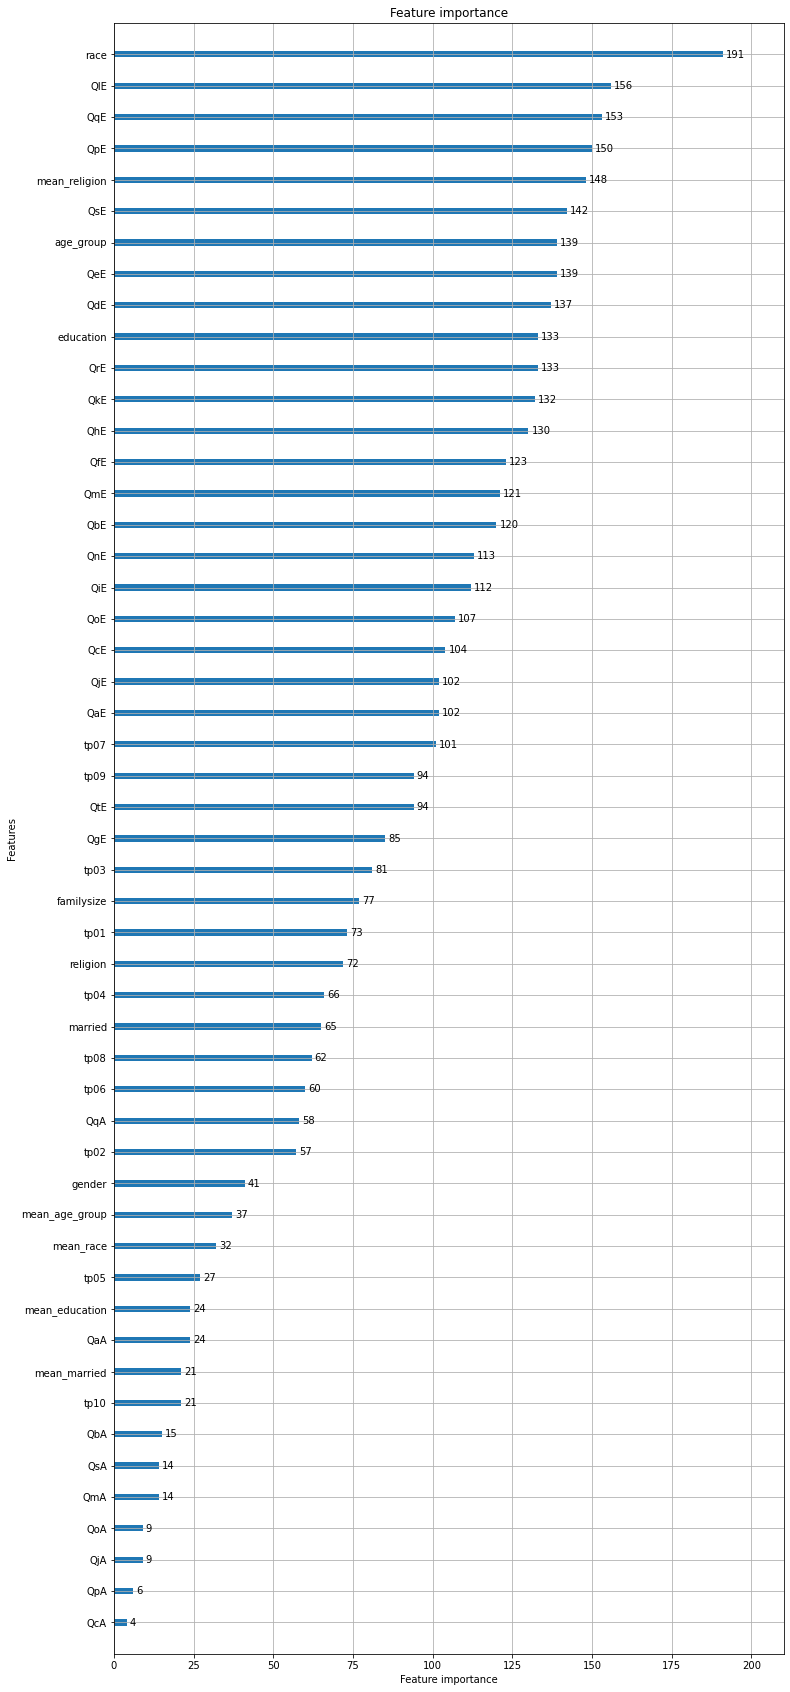

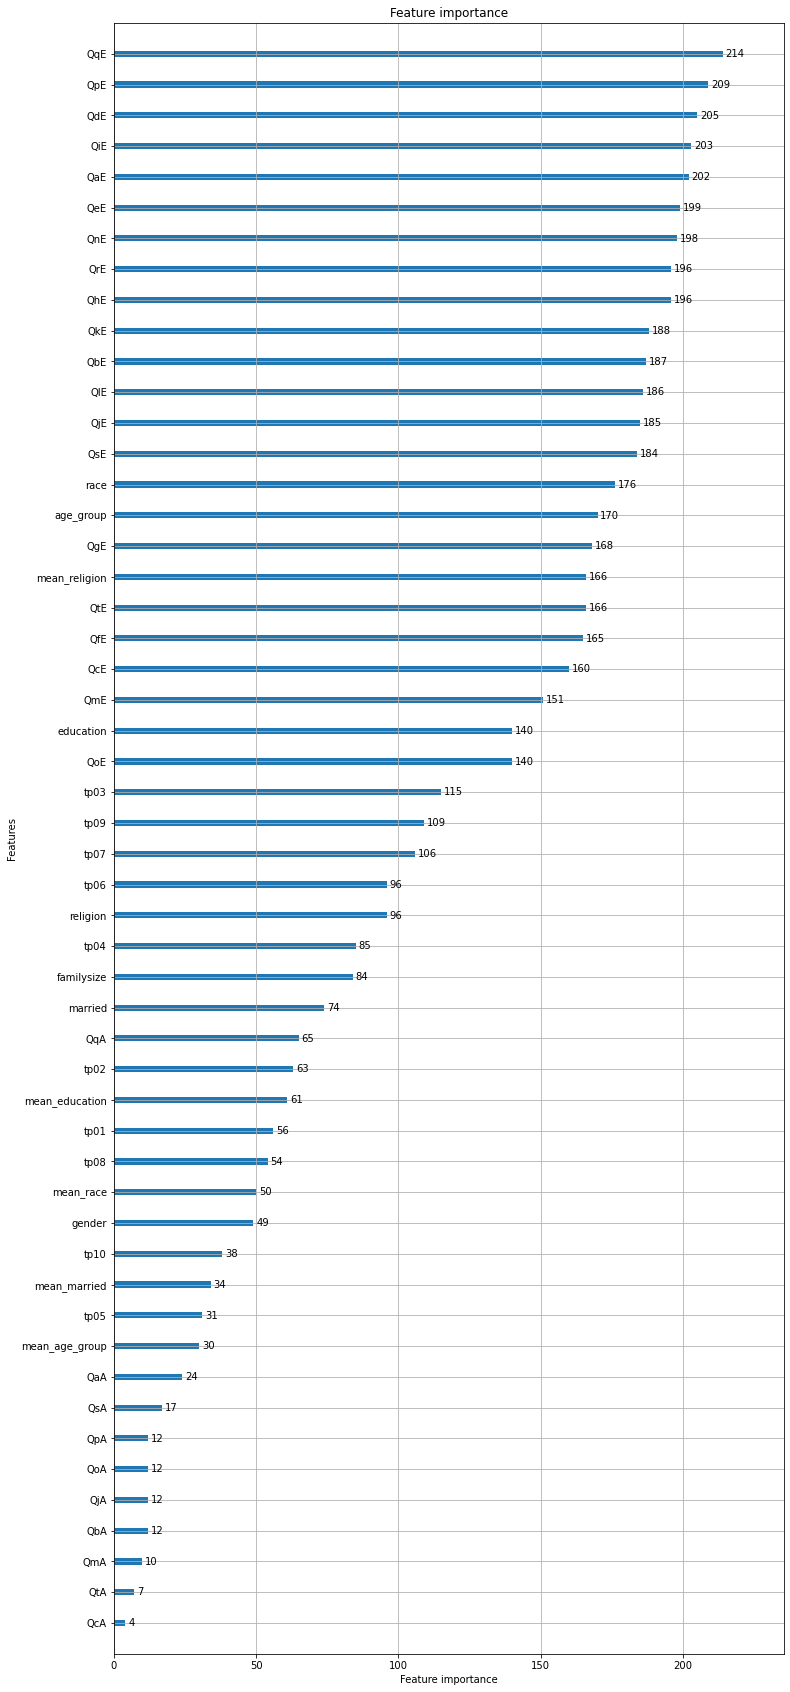

In [118]:
for model in models:
    lightgbm.plot_importance(model,figsize=(12,30))

In [119]:
submission['voted']=np.mean(preds,axis=0)+1

In [120]:
submission.to_csv('submission_mean_nottp.csv',index=False)